In [201]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import scipy.io
import time

In [202]:
# Lets read our CFD results of lift-drag ratio data containing for different airfoils

data = scipy.io.loadmat('./data/1_300.mat')

In [203]:
# Seperating X, y values from the dictionary

X, y, rNorm = data['data_x'], data['data_y'], data['Normalization_Factor']
num_data = np.shape(X)[0]

In [204]:
# Checking the sape of the X value
X.shape

(6855, 16384)

so we have 6855 examples and flattened 128-by-128 image vector <br>
we can look one of the image from our dataset below

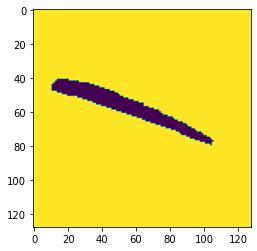

In [205]:
plt.imshow(X.reshape(-1,128,128)[17])
plt.show()

In [206]:
# Checking the shape of the X value
y.shape

(6855, 1)

 we have one lift-drag ratio value for each example

In [207]:
#train_x, train_y = X[:int(0.7*num_data)], y[:int(0.7*num_data)]
#valid_x,valid_y = X[int(0.2*num_data):int(0.9*num_data)], y[int(0.2*num_data):int(0.9*num_data)]
#test_x, test_y = X[int(0.9*num_data):], y[int(0.9*num_data):]

In [208]:
from sklearn.model_selection import train_test_split

In [209]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


In [210]:
X_val, X_train, y_val, y_train = train_test_split(X_train, y_train, test_size=0.9, random_state=42)

In [211]:
#X_train, y_train = train_x, train_y
#X_val, y_val = valid_x,valid_y
#X_test, y_test = test_x, test_y

In [212]:
print(f'Shape of Train data: {X_train.shape} \n')
print(f'Shape of Validation data: {X_val.shape} \n')
print(f'Shape of Test data: {X_test.shape}')

Shape of Train data: (4798, 16384) 

Shape of Validation data: (4798, 16384) 

Shape of Test data: (686, 16384)


In [213]:
X_train = X_train.reshape(-1,128,128,1)
X_val = X_val.reshape(-1,128,128,1)

In [214]:
# Lets define our image shape
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_CHANNELS = 1

In [215]:
#set up parameters
batch_size = 64
learning_rate = 1e-5
num_epochs = 50

In [216]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import backend as k

from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D
from tensorflow.keras.layers import Flatten, Dense, Activation, BatchNormalization, Concatenate

In [217]:
model = Sequential()

model.add(Input(shape=(IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS)))
model.add(Conv2D(10, (13, 13), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Conv2D(20, (7, 7), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Conv2D(40, (7, 7), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Conv2D(80, (5, 5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(720, activation='relu'))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [218]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 128, 128, 10)      1700      
_________________________________________________________________
batch_normalization_24 (Batc (None, 128, 128, 10)      40        
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 64, 64, 10)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 64, 64, 20)        9820      
_________________________________________________________________
batch_normalization_25 (Batc (None, 64, 64, 20)        80        
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 32, 32, 20)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 40)       

In [219]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [220]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),  #SGD(lr=0.005, momentum=0.9), #Adam(learning_rate = 2e-4),
                        loss = tf.keras.losses.MSE, #'categorical_crossentropy'
                        metrics = ['mse']) #'acc'

In [221]:
# Stop training when the val_loss has stopped decreasing for 5 epochs.
es = EarlyStopping(monitor='val_loss', mode='min', patience=5,
                       restore_best_weights=True, verbose=1)

In [222]:
STEP_SIZE_TRAIN = len(X_train)//batch_size
STEP_SIZE_VALID = len(X_val)//batch_size

In [223]:
# reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.3,
                                  patience = 3,
                                  min_lr = 1e-8,
                                  mode = 'min',
                                  verbose = 1)

# Save the model with the minimum validation loss
checkpoint_cb = ModelCheckpoint("./best_model.h5",
                                    save_best_only=True,
                                    monitor = 'val_loss',
                                    mode='min')
    
history = model.fit(x=X_train,y=y_train, validation_data=(X_val,y_val), 
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_steps = STEP_SIZE_VALID,
                    callbacks=[reduce_lr],
                    batch_size= batch_size,epochs= num_epochs)

Epoch 1/50
74/74 [==============================] - 5s 54ms/step - loss: 0.0232 - mse: 0.0232 - val_loss: 0.0888 - val_mse: 0.0888
Epoch 2/50
74/74 [==============================] - 2s 32ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0462 - val_mse: 0.0462
Epoch 3/50
74/74 [==============================] - 2s 31ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0259 - val_mse: 0.0259
Epoch 4/50
74/74 [==============================] - 2s 31ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0168 - val_mse: 0.0168
Epoch 5/50
74/74 [==============================] - 2s 31ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0124 - val_mse: 0.0124
Epoch 6/50
74/74 [==============================] - 2s 34ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 7/50
74/74 [==============================] - 2s 31ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 8/50
74/74 [==============================] - 2s 31ms/step - loss: 0.0018 - m

In [224]:
y_pred = model.predict(X_test.reshape(-1,128,128,1))
y_pred.shape

(686, 1)

In [225]:
y_test.shape

(686, 1)

In [226]:
y_pred

array([[9.52117294e-02],
       [1.37317389e-01],
       [1.80661097e-01],
       [1.49669290e-01],
       [5.64881461e-03],
       [2.49050453e-01],
       [4.54879887e-02],
       [2.22105727e-01],
       [9.74174216e-03],
       [1.54050976e-01],
       [3.17228884e-01],
       [1.31177008e-01],
       [1.28773168e-01],
       [1.42445844e-02],
       [1.29087651e-02],
       [2.83909738e-02],
       [2.11229250e-01],
       [1.72556594e-01],
       [2.48446822e-01],
       [8.59349817e-02],
       [4.36673872e-02],
       [3.06725770e-01],
       [1.99462697e-01],
       [2.57313728e-01],
       [4.29849625e-01],
       [2.38220096e-01],
       [1.48572311e-01],
       [3.11857522e-01],
       [1.47079257e-02],
       [4.33496246e-03],
       [8.14095587e-02],
       [1.79611355e-01],
       [3.08640510e-01],
       [6.59292145e-03],
       [1.53463140e-01],
       [1.11122370e-01],
       [5.64211421e-02],
       [5.67709841e-03],
       [2.22954080e-01],
       [3.97648007e-01],


In [227]:
y_test

array([[ 1.57560195e-01],
       [ 1.54315172e-01],
       [ 1.96634555e-01],
       [ 1.36135422e-01],
       [-8.82338568e-02],
       [ 2.04643344e-01],
       [ 6.43050000e-02],
       [ 2.06547102e-01],
       [ 1.01351492e-02],
       [ 2.22378821e-01],
       [ 3.16324697e-01],
       [ 7.75861628e-02],
       [ 2.02658356e-01],
       [ 3.57769419e-02],
       [ 1.04272113e-02],
       [ 3.48198523e-02],
       [ 1.92135775e-01],
       [ 1.75038228e-01],
       [ 2.22847139e-01],
       [ 4.58585505e-02],
       [ 7.06223930e-02],
       [ 3.23670313e-01],
       [ 2.60771141e-01],
       [ 2.49661407e-01],
       [ 2.75275737e-01],
       [ 2.42481002e-01],
       [ 1.99117182e-01],
       [ 2.60398454e-01],
       [ 2.83117502e-02],
       [ 1.10306852e-02],
       [ 5.58745602e-02],
       [ 1.13561972e-01],
       [ 1.92665000e-01],
       [ 1.25852745e-02],
       [ 1.64494386e-01],
       [ 1.07778044e-01],
       [ 4.51559923e-02],
       [-6.18399459e-02],
       [ 2.6

In [228]:
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, r2_score

In [229]:
r2_score(y_test,y_pred)

0.7798580569793718

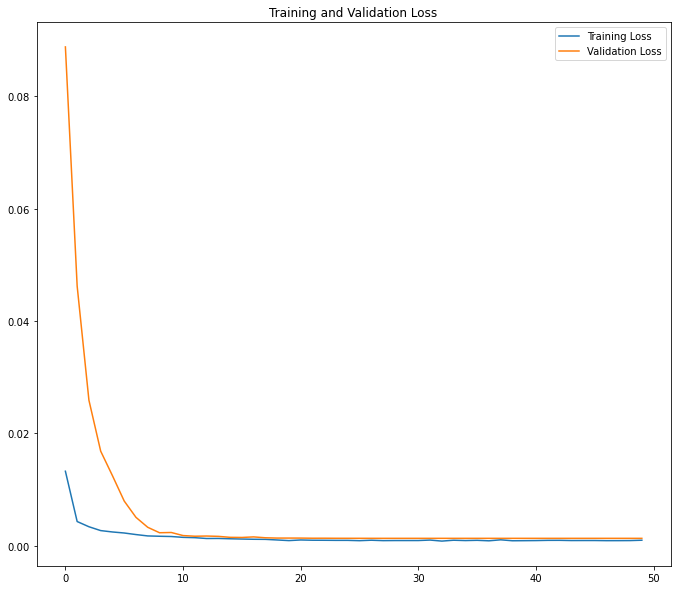

In [230]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(25, 10))


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Text(0.5, 1.0, ' Test & Predicted Cl/Cd Ratio')

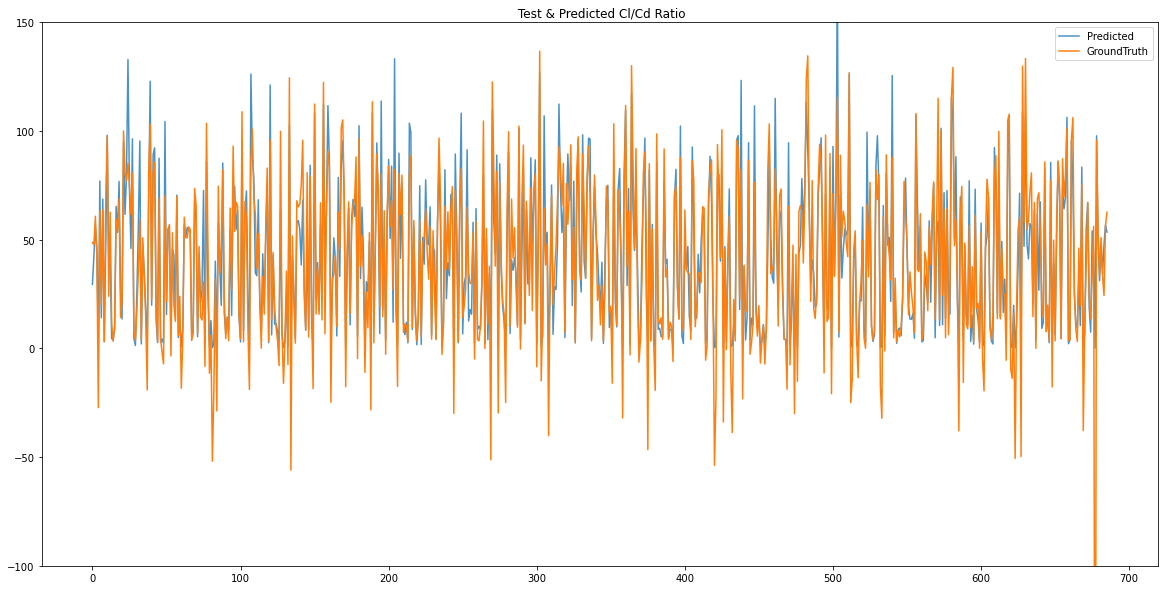

In [231]:
#denormalize
predyList = [x*rNorm[0,0] for x in y_pred]
testyList = [x*rNorm[0,0] for x in y_test]
#plot result
plt.figure(figsize=(20, 10))
line3, = plt.plot(range(len(predyList)), predyList, alpha = 0.8,label = 'Predicted')
line4, = plt.plot(range(len(testyList)), testyList, label = 'GroundTruth')
plt.ylim(-100,150)
plt.legend([line3,line4],['Predicted','GroundTruth'])
plt.title(' Test & Predicted Cl/Cd Ratio')

Text(0.5, 1.0, ' Test & Predicted Cl/Cd Ratio (Zoom In)')

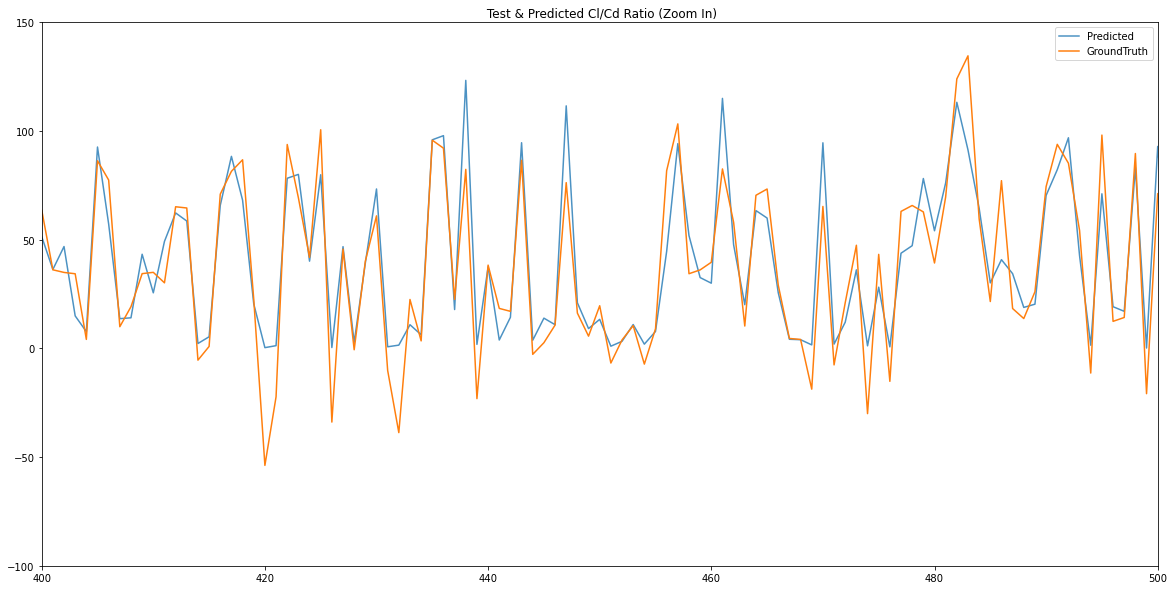

In [232]:
#plot result(zoom in)
plt.figure(figsize=(20,10))
line5, = plt.plot(range(len(predyList)), predyList, alpha = 0.8,label = 'Predicted')
line6, = plt.plot(range(len(testyList)), testyList, label = 'GroundTruth')
plt.ylim(-100,150)
plt.xlim(400,500)
plt.legend([line5,line6],['Predicted','GroundTruth'])
plt.title(' Test & Predicted Cl/Cd Ratio (Zoom In)')

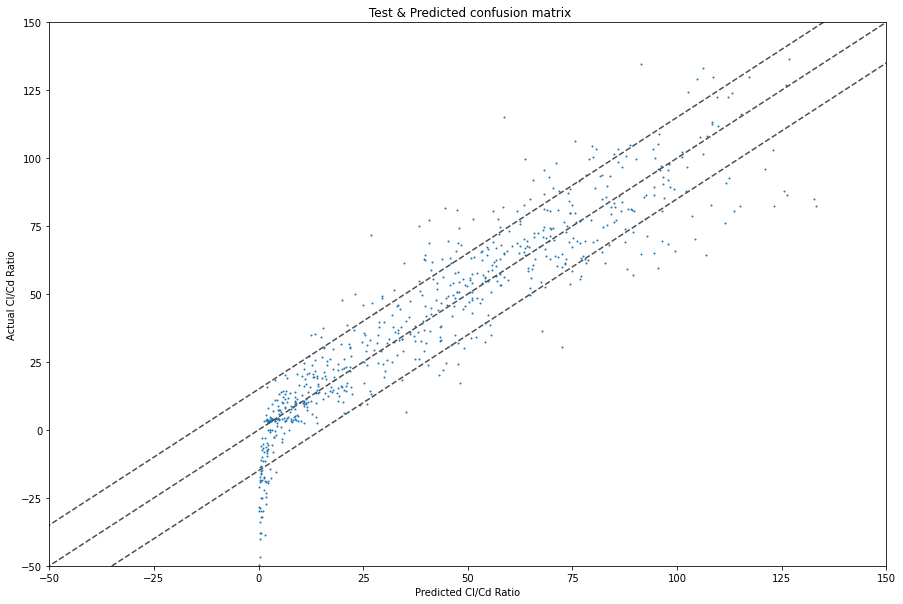

In [233]:
plt.figure(figsize=(15,10))
pre = [x for x in predyList]
test = [x for x in testyList]
#plt.figure()
plt.scatter(pre, test,s=1)
#plt.scatter(y_pred, y_test,s=1)
plt.plot([-150,150],[-150,150], ls="--",c=".3")
plt.plot([-150,135],[-135,150], ls="--",c=".3")
plt.plot([-135,150],[-150,135], ls="--",c=".3")
plt.xlabel('Predicted Cl/Cd Ratio')
plt.ylabel('Actual Cl/Cd Ratio')
plt.xlim(-50,150)
plt.ylim(-50,150)
plt.title(' Test & Predicted confusion matrix')
plt.show()